### Comments :
1. (7/24/25) Much of the variance happens at the chest level (breathing motion changes) and paws. I suspect most facial components are masked by this imbalance (they are captured, but presumably displaced in the eigenspectrum) --> ROI analysis would be an interesting take (suggested by McNamee), take most representative components of each ROI and merge to get a categorized behavioral motif spectrum.

## Fetch and setup

In [ ]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io
from psyfun.config import *
from psyfun import plots
import matplotlib as pl
from matplotlib import pyplot as plt

one = ONE()

# only run if first-time setup 

#%run -i fetchdata.py -a

# Load session and insertion metadata
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

# dropping na (PCA_DC)
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])

# Create a DataFrame with eids (all sessions with a left vid), categorized by experimental group
eids_exp = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == False), 'eid']
eids_cont = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == True), 'eid']

In [ ]:
epoch_pre = [
    'task00_spontaneous', 
    'task00_rfm',
    'task00_replay'
]

epoch_post =[
    'task01_spontaneous', 
    'task01_rfm',
    'task01_replay'
]

## Video QC

c:\Users\marti\Documents\mainen\psychedelics\psyfun\plots.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_qc = df[qc_columns].replace(qcval2num)


'\nVideo data for most sessions, only three missing. Good?\n'

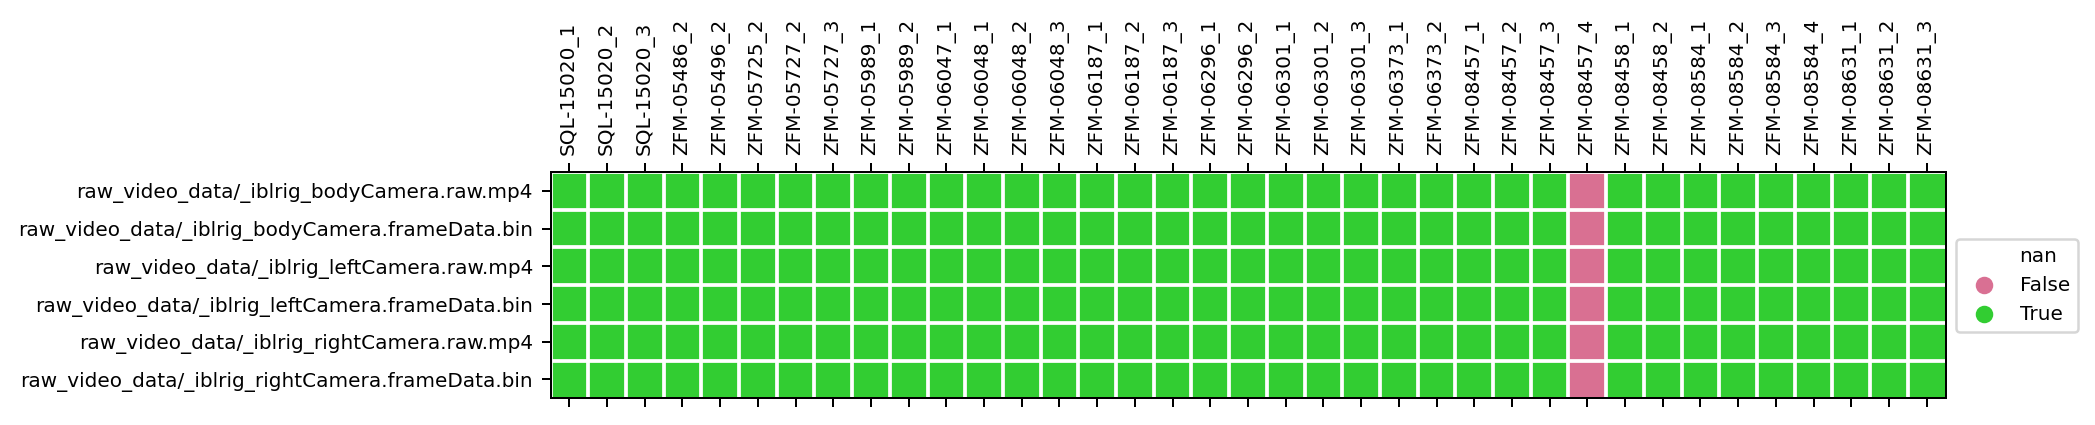

In [5]:
# Check which video datasets exist for each session
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_datasets['video'],  qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

"""
Video data for most sessions, only three missing. Good?
"""

'\nLeft cameras have constant ~60FPS and a null number of dropped frames.\nThe one thing about higher FPS is that FaceMap will have to work with higher binning parameters to optimize the process,\ncausing a high loss of information.\n\nNonetheless, important to compare left and right video, especially because right videos also have a lower dropped-frame rate.\n'

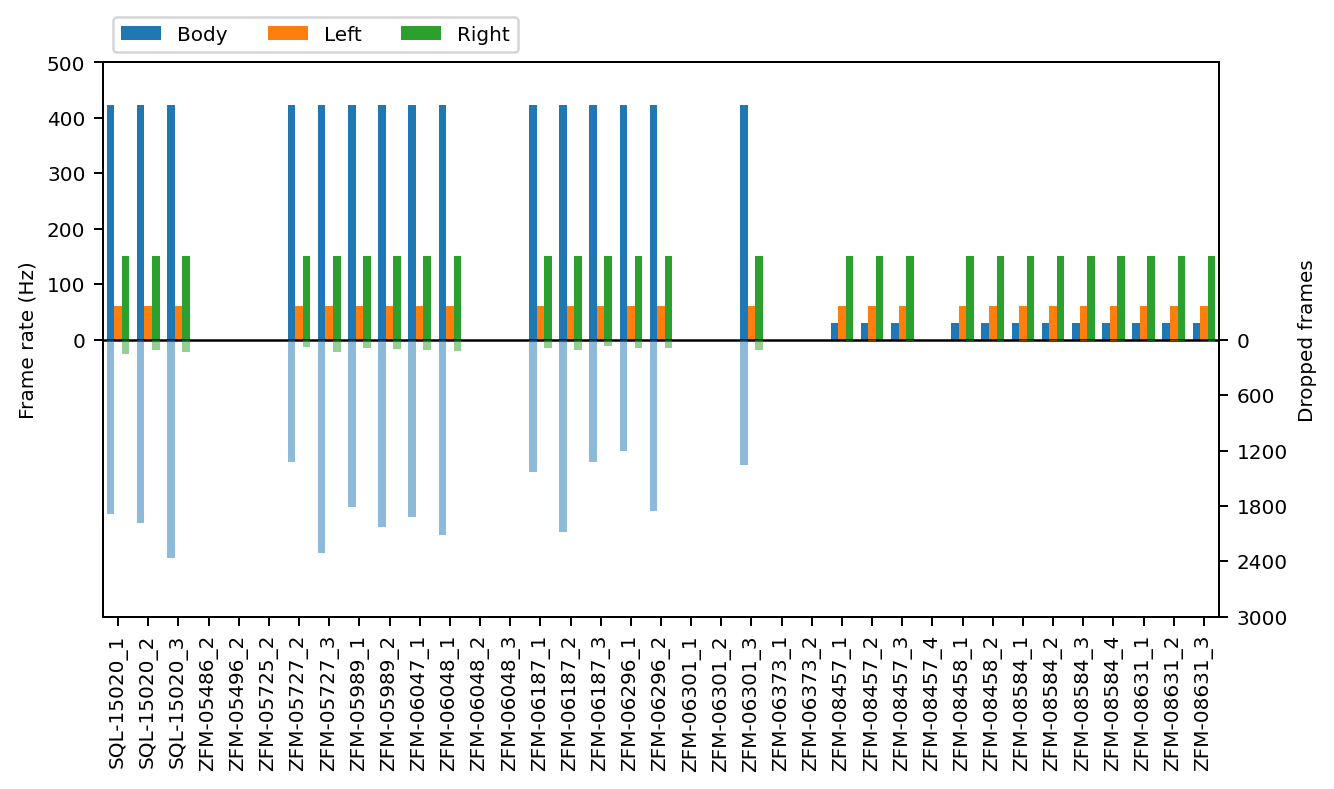

In [ ]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)


# Left cameras have constant ~60FPS and a null number of dropped frames.
# Have not checked different results depending on camera orientation

# Extraction

Stringer's FaceMap algorithm is the basis of extraction (Stringer et al 2019).
I tried different methods to tractably compute SVD on video data, but given the high resolution, video length, and number of videos, the best option was the pixel-downsampling + concatenated PCs FaceMap method. 
The problem with that algorithm is that it can only process full videos. To avoid clipping videos (which is also incredibly time-consuming), I implemented a subclip feature that takes interval (start_time, end_time) and runs a FaceMap PCA on it.

 Some things to consider before running a full-screen video analysis:

- There are prominent activity clusters in the machine side instead of the rodent. They might be zeroed by motion energy cenering
- Defining ROI might be useful; must check if the shape of all videos is the same to integrate into the pipeline.
- ROI manipulation through the API is slightly more complex than through the GUI due to binning and standardization: need to use the transforms.

Edit (24/6/25):

- I've given up on trying to implement an automatic pipeline to run each video: the API resists any call within the code.
- With ~45 videos, I'll run the GUI with each and create an analysis pipeline for the results.

Edit (7/1/25)
- I ended up reimplementing a specialized version of Facemap that runs extraction on video subclips (epochs) without video segmentation.

Edit (7/18/25)
- Problem with the temporal projections. Only first chunk projected.
  Be careful about  chunks. Also, try to initialize with NaNs insted of zeroes to mark for errors.

Edit (7/19/25)
- Problem fixed (18h of reprocessing all the projections). Implemented another function in MotionMap s.t. only projections
  were computed given a set of eigenfaces (past partially corrupted results).

### Functions

In [ ]:
import os
import numpy as np

def download_video(eid, camera = "left"):
    """
    Downloads raw video data from specific session. Camera parameter can be switched to "body" and "right".
    
    Parameters
    ----------
    eid (str): Experiment/session identifier

    camera (str): Camera orientation identifier (left by default). "body", "right" are other available options.

    Returns
    -------
    video_path: Local path for saved video
    """
    
    if camera == "left":
        video_path = one.load_dataset(eid, f'*leftCamera.raw*', collection='raw_video_data')
    elif camera == "right":
        video_path = one.load_dataset(eid, f'*rightCamera.raw*', collection='raw_video_data')
    elif camera == "body":
        video_path = one.load_dataset(eid, f'*bodyCamera.raw*', collection='raw_video_data')
    else:
         raise ValueError(f"Unknown camera parameter: {camera}")

    return video_path

def get_time_epochs(df_sessions, eid):
    video_data = df_sessions.loc[df_sessions['eid'] == eid]
    
    # epochs
    epoch_pre = [
        ("task00_spontaneous", video_data['task00_spontaneous_start'].values[0], video_data['task00_spontaneous_stop'].values[0]),
        ("task00_rfm", video_data['task00_rfm_start'].values[0], video_data['task00_rfm_stop'].values[0]),
        ("task00_replay", video_data['task00_replay_start'].values[0], video_data['task00_replay_stop'].values[0])
    ]

    epoch_post = [
        ("task01_spontaneous", video_data['task01_spontaneous_start'].values[0], video_data['task01_spontaneous_stop'].values[0]),
        ("task01_rfm", video_data['task01_rfm_start'].values[0], video_data['task01_rfm_stop'].values[0]),
        ("task01_replay", video_data['task01_replay_start'].values[0], video_data['task01_replay_stop'].values[0])
    ]

    return epoch_pre, epoch_post

In [ ]:
#----------------------ONLY RUN ONCE-----------------------------------
# experimental group (27 videos)

#for eid in eids_exp:
    #video_path = download_video(eid)

# Control group (9 videos)
#for eid in eids_cont:
    #video_path = download_video(eid)

## MotionMap: processing subclips

Things to think about:
- Computed_means() depends on a subset of frames in the subclip (e.g., average abs. motion energy in 1000 frames). Is that representative for an epoch (~18000 frames).

In [ ]:
def expected_path(video_path, start_sec, end_sec):
    """
    Constructs expected path to check if epoch was already processed.
    """
    basename, filename = os.path.split(video_path)
    filename, _ = os.path.splitext(filename)
    epoch_str = f"_start{int(start_sec)}_end{int(end_sec)}"
    expected_save = os.path.join(basename, f"{filename}{epoch_str}_proc.npy")

    return expected_save

### LSD group

In [2]:
import motionmap
import ibllib.io.video as vidio

results = []  # List to store (eid, epoch, savename)

for eid in eids_exp:
    # epoch timing 
    epoch_pre, epoch_post = get_time_epochs(df_sessions, eid)

    # Get video path
    url = one.eid2path(eid)
    if not os.path.exists(url):
        video_path = download_video(eid)
    
    video_path = os.path.join(url, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
    path = [[video_path]]
    
    meta = vidio.get_video_meta(video_path)
    fps = meta['fps']

    # Run for each pre-epoch
    for epoch_name, start_sec, end_sec in epoch_pre:
        # expected save path
        expected_save = expected_path(video_path, start_sec, end_sec) 
        if os.path.exists(expected_save):
            print(f"Skipping {eid} pre_{epoch_name}: already processed at {expected_save}")
            results.append((eid, f'pre_{epoch_name}', expected_save))
            continue

        print("Running session: ", eid, " - epoch: ", epoch_name)
        savename = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)
        results.append((eid, f'pre_{epoch_name}', savename))

    # Run for each post-epoch
    for epoch_name, start_sec, end_sec in epoch_post:
        expected_save = expected_path(video_path, start_sec, end_sec) 
        if os.path.exists(expected_save):
            print(f"Skipping {eid} post_{epoch_name}: already processed at {expected_save}")
            results.append((eid, f'post_{epoch_name}', expected_save))
            continue

        print("Running session: ", eid, " - epoch: ", epoch_name)
        savename = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)
        results.append((eid, f'post_{epoch_name}', savename))

NameError: name 'eids_exp' is not defined

In [ ]:
results_df = pd.DataFrame(results)
results_df.columns = ["eid", "epoch", "savename"]
results_df.to_csv('exp_results', index=False)

### Saline Group

If you are running this for the first time, I'd suggest you parallelize. Takes about 25h~ for LSD, some 10h for control.

In [ ]:
import motionmap
import ibllib.io.video as vidio

results = []  # List to store (eid, epoch, savename)

for eid in eids_cont:
    # epoch timing 
    epoch_pre, epoch_post = get_time_epochs(df_sessions, eid)

    # Get video path
    url = one.eid2path(eid)
    if not os.path.exists(url):
        video_path = download_video(eid)
    
    video_path = os.path.join(url, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
    path = [[video_path]]
    
    meta = vidio.get_video_meta(video_path)
    fps = meta['fps']

    # Run for each pre-epoch
    for epoch_name, start_sec, end_sec in epoch_pre:
        # expected save path
        expected_save = expected_path(video_path, start_sec, end_sec) 
        if os.path.exists(expected_save):
            print(f"Skipping {eid} pre_{epoch_name}: already processed at {expected_save}")
            results.append((eid, f'pre_{epoch_name}', expected_save))
            continue

        print("Running session: ", eid, " - epoch: ", epoch_name)
        savename = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)
        results.append((eid, f'pre_{epoch_name}', savename))

    # Run for each post-epoch
    for epoch_name, start_sec, end_sec in epoch_post:
        expected_save = expected_path(video_path, start_sec, end_sec) 
        if os.path.exists(expected_save):
            print(f"Skipping {eid} post_{epoch_name}: already processed at {expected_save}")
            results.append((eid, f'post_{epoch_name}', expected_save))
            continue

        print("Running session: ", eid, " - epoch: ", epoch_name)
        savename = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)
        results.append((eid, f'post_{epoch_name}', savename))

In [ ]:
results_df = pd.DataFrame(results)
results_df.columns = ["eid", "epoch", "savename"]

results_df.to_csv('cont_results', index=False)

In [ ]:
import facemap

## Loading results

In [1]:
motion = results['motion'][0]

print(len(motion))

NameError: name 'results' is not defined

In [ ]:

print(len(results['motMask'][0]))


avgtest = np.stack(avgmotion, axis=0)
print(avgtest.shape)
print(avgtest)

65786
(256, 320)
[[8.494634   0.7836491  0.3111742  ... 0.88554287 0.7412878  0.86881316]
 [0.85315657 0.7337121  0.39501265 ... 0.81635106 0.7881945  0.6999999 ]
 [0.411553   0.32979795 0.31445706 ... 0.91900253 0.85744953 0.8291667 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Temporal masks: full video, frame-level SVD (frame x component)

frame_masks = results['motSVD']
frame_masks = np.stack(frame_masks[0], axis = 0) 
print(frame_masks.shape) 

# Eigenfaces: each 
eigenmsk = results ['motMask'] # binned pixels x components
eigenmsk=np.stack(eigenmsk[0], axis = 0)
print(eigenmsk.shape)

# Reshaped eigenfaces
re_eigenmsk = results['motMask_reshape'] # reshaped by bins (x, y, components)
re_eigenmsk=np.stack(re_eigenmsk[0], axis = 0)
print(re_eigenmsk.shape)

# Eigenvalues: they are in order (sanity check)
eigenval = results['motSv']

(1800, 500)
(81920, 500)
(256, 320, 500)


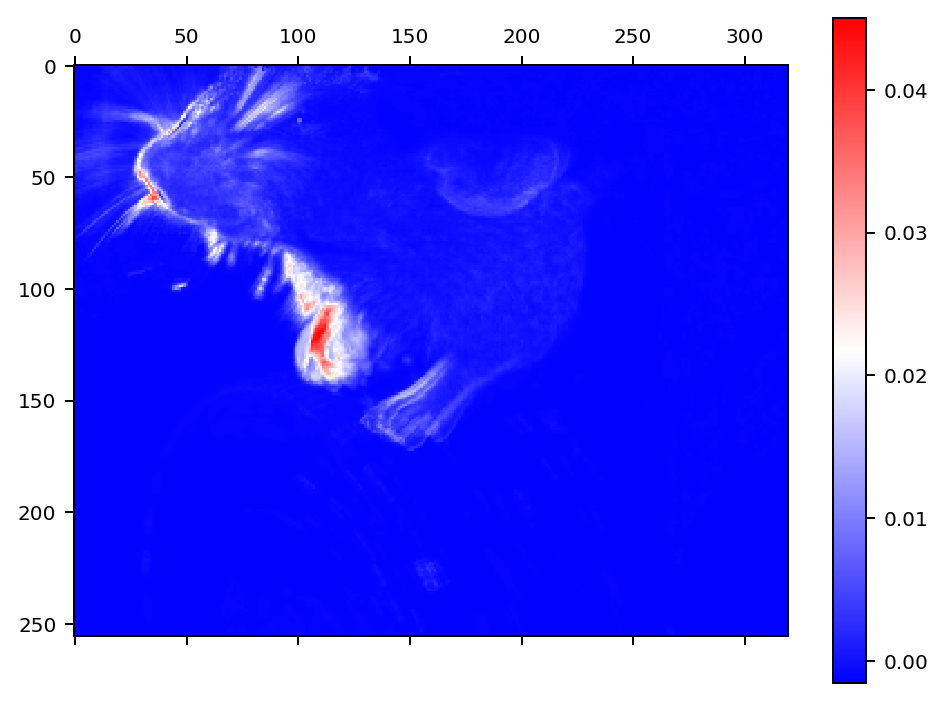

In [ ]:
# First eigenmask (by interpolation)
# I assume the change due to high values at the limb level,
# thus masking the other motion

fig, ax = plt.subplots()
im = ax.matshow(re_eigenmsk[:,:,0], cmap='bwr', interpolation='nearest')
fig.colorbar(im, ax=ax)

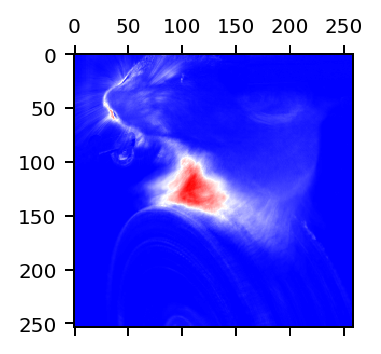

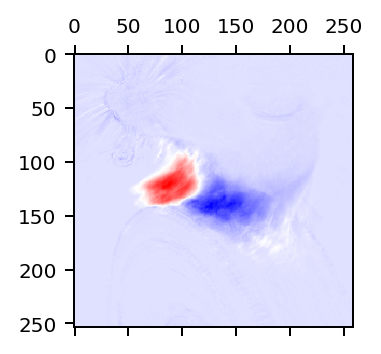

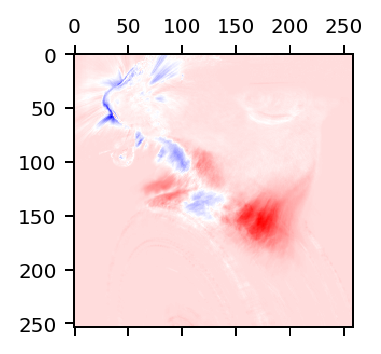

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(figsize = (2,2))
    axs.matshow(re_eigenmsk[:,:,i], cmap = "bwr", interpolation = 'nearest')
    plt.show()